# Twitter Bot or Not? 

    ~~~~ Write a nice intro here

In [1]:
# Basics
import pandas as pd
import psycopg2 as pg
import numpy as np
import pickle

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from model_evaluation import *

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model support
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve)

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

## Data import and set up

In [2]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',             # Connecting to _local_ version of psql
    'dbname': 'twitter_accounts',    # DB with Twitter info
    'port': 5432                     # port we opened on AWS
}

connection = pg.connect(**connection_args)

In [3]:
raw_df = pd.read_sql('SELECT * FROM human_bots', connection)

In [4]:
# drop funny index column
raw_df.drop(columns=['index'], inplace=True)

# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour

In [5]:
# usable df setup
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'acct_location', 'geo_enabled', 'lang', 
             'default_profile', 'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 
             'statuses_count', 'average_tweets_per_day', 'account_age_days']]

In [6]:
del raw_df

In [7]:
# Interesting features to look at: 
df['avg_daily_followers'] = np.round((df['followers_count'] / df['account_age_days']), 3)
df['avg_daily_friends'] = np.round((df['followers_count'] / df['account_age_days']), 3)
df['avg_daily_favorites'] = np.round((df['followers_count'] / df['account_age_days']), 3)

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible interactive features
df['network'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1 + df['statuses_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

In [8]:
df.head()

,bot,screen_name,created_at,hour_created,verified,acct_location,geo_enabled,lang,default_profile,default_profile_image,...,avg_daily_favorites,friends_log,followers_log,favs_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,1,best_in_dumbest,2016-10-15 21:32:11,21,0,unknown,0,en,0,0,...,1.133,1.609,7.371,1.609,2.183,11.860,68.625,0.757,0.003,0.003
1,0,CJRubinPhoto,2016-11-09 05:01:30,5,0,Estados Unidos,0,en,0,0,...,0.624,6.781,6.758,6.286,0.168,45.826,37.395,0.485,0.494,0.494
2,0,SVGEGENT,2017-06-17 05:34:27,5,0,"Los Angeles, CA",1,en,0,0,...,0.148,6.389,5.153,8.104,0.623,32.923,35.608,0.138,0.414,0.414
3,0,TinkerVHELPK5,2016-07-21 13:32:25,13,0,"Birmingham, AL",1,en,1,0,...,0.347,6.452,6.250,9.040,0.636,40.325,44.932,0.298,0.354,0.354
4,0,JoleonLescott,2012-01-15 16:32:35,16,1,"England, United Kingdom",1,en,0,0,...,240.178,4.762,13.533,4.489,0.850,64.444,112.911,5.486,0.036,0.036


In [9]:
features = ['verified', 
            #'created_at',
            #'hour_created',
            #'lang',
            #'acct_location',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

In [10]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

## Basic model evaluation

In [11]:
# Models that require scaling: 
knn = KNeighborsClassifier(n_neighbors=10)
lr = LogisticRegression()

# Scaling
scalar = StandardScaler()
scalar.fit(X)
X_train_scaled = scalar.transform(X)

model_list = [knn, lr]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [12]:
multi_model_eval(model_list, X_train_scaled, y, kf)

Model: KNeighborsClassifier(n_neighbors=10)
------------------------------
Accuracy:  0.83767 +- 0.004042
Precision: 0.80131 +- 0.006912
Recall:    0.68362 +- 0.013989
F1 Score:  0.73768 +- 0.006909
ROC AUC:   0.89569 +- 0.003649

Model: LogisticRegression()
------------------------------
Accuracy:  0.80314 +- 0.002075
Precision: 0.71114 +- 0.006977
Recall:    0.69157 +- 0.010010
F1 Score:  0.70113 +- 0.003798
ROC AUC:   0.85181 +- 0.002741



In [13]:
# Models that don't require scaling
gnb = gnb = GaussianNB()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
xgb = XGBClassifier()

model_list = [gnb, tree, forest, xgb]
kf = KFold(n_splits=3, shuffle=True, random_state=33)

In [14]:
multi_model_eval(model_list, X, y, kf)

Model: GaussianNB()
------------------------------
Accuracy:  0.69503 +- 0.059328
Precision: 0.55385 +- 0.090251
Recall:    0.82332 +- 0.138664
F1 Score:  0.64431 +- 0.011958
ROC AUC:   0.82068 +- 0.002617

Model: DecisionTreeClassifier()
------------------------------
Accuracy:  0.81046 +- 0.001882
Precision: 0.71176 +- 0.001585
Recall:    0.72681 +- 0.001538
F1 Score:  0.71921 +- 0.001561
ROC AUC:   0.78958 +- 0.001596

Model: RandomForestClassifier()
------------------------------
Accuracy:  0.86873 +- 0.003304
Precision: 0.84583 +- 0.007664
Recall:    0.74240 +- 0.007832
F1 Score:  0.79069 +- 0.004571
ROC AUC:   0.92460 +- 0.002592

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints

RandomForest and XGBoost seem most promising. 

Will look at ROC Curve for each next. 

Average AUC Score: 0.9261 +- 0.003417


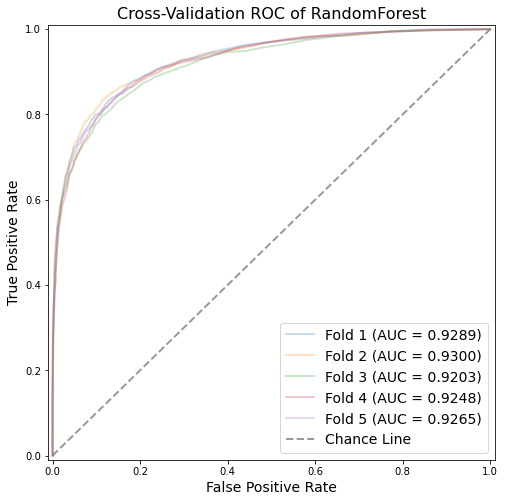

In [15]:
forest = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

Average AUC Score: 0.9274 +- 0.004188


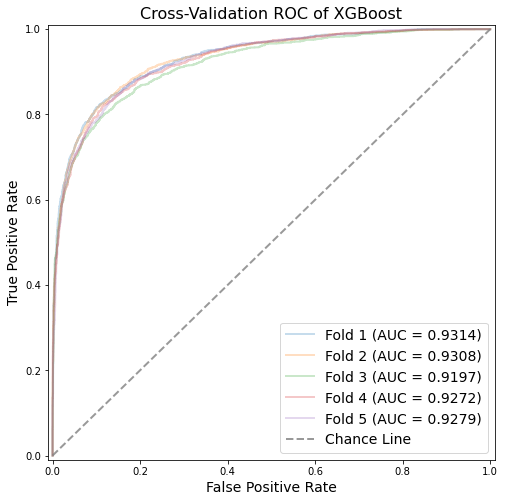

In [16]:
xgb = XGBClassifier()

kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

## Class weight balancing

In [17]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print(f'Bots / Total %: {(num_bots / len(df))*100:.2f}')

Number of bots:  12425
Number of humans:  25013
Bots / Total %: 33.19


In [18]:
# For XGBoost
estimate = num_humans/num_bots
estimate

2.013118712273642

In [19]:
forest = RandomForestClassifier(class_weight='balanced')
xgb = XGBClassifier(scale_pos_weight=estimate)

models = [forest, xgb]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [20]:
multi_model_eval(models, X, y, kf)

Model: RandomForestClassifier(class_weight='balanced')
------------------------------
Accuracy:  0.87018 +- 0.003582
Precision: 0.85382 +- 0.011003
Recall:    0.73770 +- 0.009795
F1 Score:  0.79144 +- 0.006243
ROC AUC:   0.92620 +- 0.003752

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.013118712273642,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
------------------------------
Accuracy:  0.86152 +- 0.004743
Precision: 0.78358 +- 0.009921
Recall:    0.80858 +- 0.007697
F1 Score:  0.79

XGBoost stands out bing more balanced between Precision and Recall

Let's look at a confusion matrix for a single instance.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3333)

In [22]:
xgb = XGBClassifier(scale_pos_weight=estimate)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.8571
Precision: 0.7723
Recall:    0.7969
F1 Score:  0.7844

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4415
           1       0.77      0.80      0.78      2137

    accuracy                           0.86      6552
   macro avg       0.84      0.84      0.84      6552
weighted avg       0.86      0.86      0.86      6552




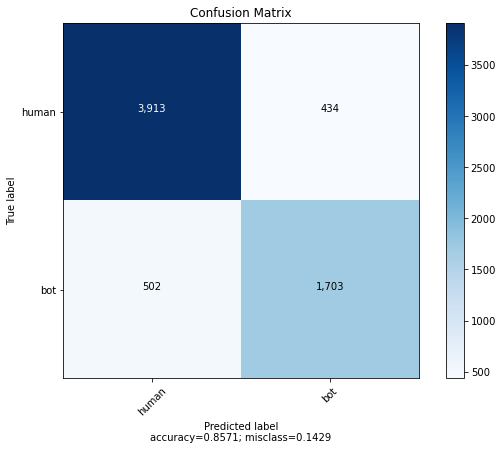

In [23]:
metrics_report(preds, y_val)

Dipping my toe into tuning parameters further...

In [24]:
xgb = XGBClassifier(scale_pos_weight=estimate, 
                   tree_method='approx')

model_list = [xgb]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

multi_model_eval(model_list, X, y, kf)

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.013118712273642,
              subsample=1, tree_method='approx', validate_parameters=1,
              verbosity=None)
------------------------------
Accuracy:  0.86350 +- 0.005646
Precision: 0.78572 +- 0.010845
Recall:    0.81295 +- 0.008397
F1 Score:  0.79909 +- 0.008964
ROC AUC:   0.92654 +- 0.003916



Average AUC Score: 0.9265 +- 0.003916


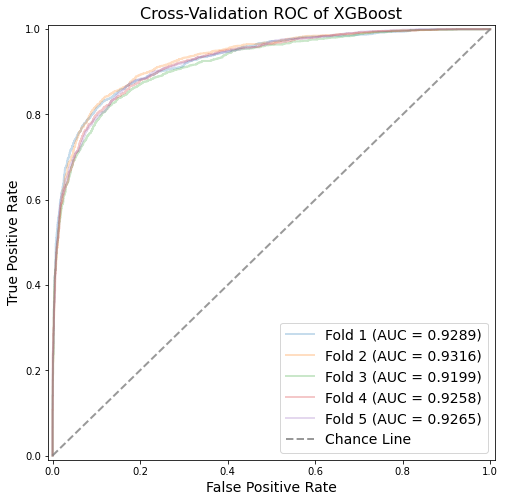

In [25]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

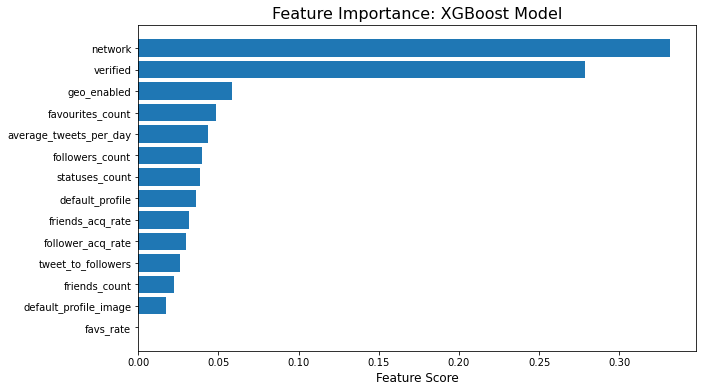

In [26]:
plot_feature_importance(xgb, features)

## Continued Tuning and Feature Selection

In [27]:
df.head(3)

,bot,screen_name,created_at,hour_created,verified,acct_location,geo_enabled,lang,default_profile,default_profile_image,...,avg_daily_favorites,friends_log,followers_log,favs_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,1,best_in_dumbest,2016-10-15 21:32:11,21,0,unknown,0,en,0,0,...,1.133,1.609,7.371,1.609,2.183,11.860,68.625,0.757,0.003,0.003
1,0,CJRubinPhoto,2016-11-09 05:01:30,5,0,Estados Unidos,0,en,0,0,...,0.624,6.781,6.758,6.286,0.168,45.826,37.395,0.485,0.494,0.494
2,0,SVGEGENT,2017-06-17 05:34:27,5,0,"Los Angeles, CA",1,en,0,0,...,0.148,6.389,5.153,8.104,0.623,32.923,35.608,0.138,0.414,0.414


In [28]:
features = ['verified', 
            #'created_at',
            'hour_created',
            #'lang',
            #'acct_location',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            #'favs_rate'
           ]

X = df[features]
y = df['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

In [29]:
xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

model_list = [xgb]

In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

multi_model_eval(model_list, X, y, kf)

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0.05,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)
------------------------------
Accuracy:  0.86869 +- 0.005360
Precision: 0.80354 +- 0.009730
Recall:    0.80312 +- 0.009279
F1 Score:  0.80331 +- 0.008852
ROC AUC:   0.93102 +- 0.003795



```
Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0.05,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)
------------------------------
Accuracy:  0.86873 +- 0.004268
Precision: 0.80355 +- 0.007634
Recall:    0.80325 +- 0.009212
F1 Score:  0.80338 +- 0.007442
ROC AUC:   0.93030 +- 0.003970
```

Average AUC Score: 0.9310 +- 0.003795


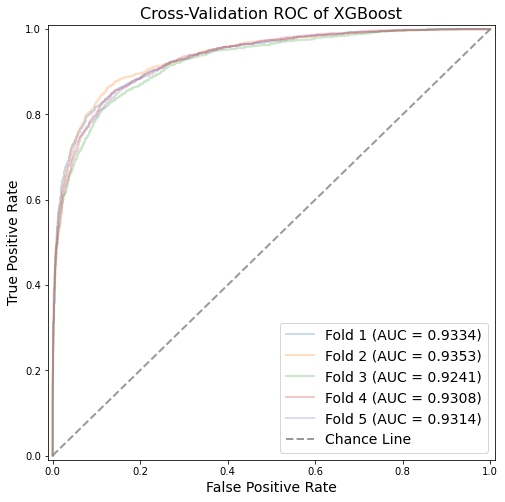

In [31]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

## Full Train & Test

In [32]:
# Full train & test
best_model = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

In [33]:
best_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0.05,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

Classification Metrics Report
-----------------------------
Accuracy:  0.8770
Precision: 0.8136
Recall:    0.8091
F1 Score:  0.8114

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      7559
           1       0.81      0.81      0.81      3673

    accuracy                           0.88     11232
   macro avg       0.86      0.86      0.86     11232
weighted avg       0.88      0.88      0.88     11232




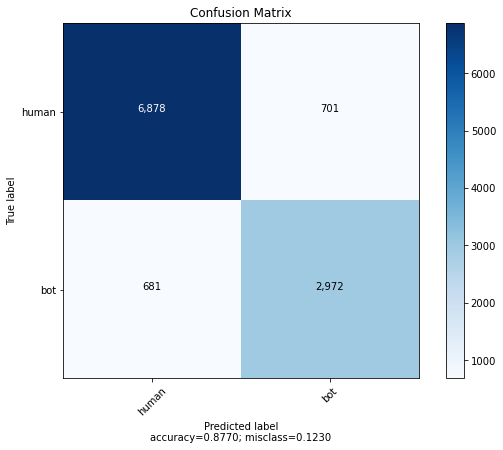

In [34]:
best_model_prediction = best_model.predict(X_test)

metrics_report(best_model_prediction, y_test)

```
Accuracy:  0.8757
Precision: 0.8112
Recall:    0.8081
F1 Score:  0.8096
```    

ROC AUC score: 0.9336



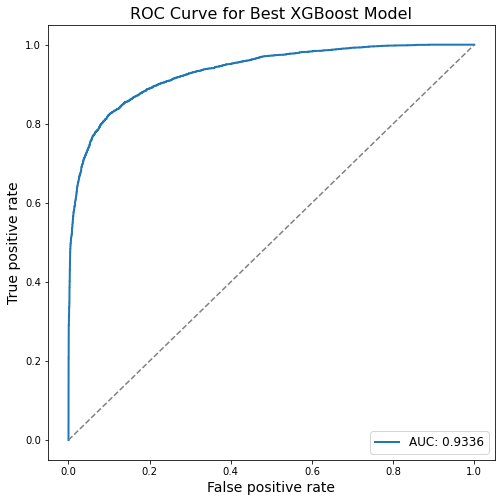

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

model_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr,lw=2, label=f'AUC: {model_auc:.4f}')
plt.plot([0,1],[0,1],c='grey',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC Curve for Best XGBoost Model', fontsize=16)
plt.legend(loc='lower right', prop={'size': 12})
print(f'ROC AUC score: {model_auc:.4f}')
print("")
plt.show();

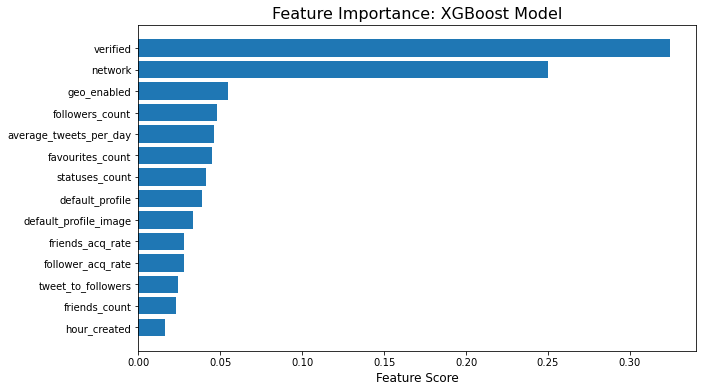

In [36]:
plot_feature_importance(best_model, features)

## Making predictions on real users!

In [37]:
scrapfish = [False, 14, False, True, False, 17, 2, 62, 14, 0.133, 4.552, 2.465, 0.019, 0.464]
scrap = np.matrix(scrapfish)
scrap

matrix([[0.000e+00, 1.400e+01, 0.000e+00, 1.000e+00, 0.000e+00,
         1.700e+01, 2.000e+00, 6.200e+01, 1.400e+01, 1.330e-01,
         4.552e+00, 2.465e+00, 1.900e-02, 4.640e-01]])

In [38]:
scrap_proba = best_model.predict_proba(scrap)[:,1][0]
scrap_proba

0.5784135

In [39]:
fish_df = pd.DataFrame(scrap, columns=features)
fish_df

,verified,hour_created,geo_enabled,default_profile,default_profile_image,favourites_count,followers_count,friends_count,statuses_count,average_tweets_per_day,network,tweet_to_followers,follower_acq_rate,friends_acq_rate
0,0.0,14.0,0.0,1.0,0.0,17.0,2.0,62.0,14.0,0.133,4.552,2.465,0.019,0.464


In [40]:
best_model.predict(fish_df)[0]

1

## Train model on the data dataset to use for new predictions

In [41]:
features = ['verified', 
            #'created_at',
            'hour_created',
            #'lang',
            #'acct_location',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            #'favs_rate'
           ]

X = df[features]
y = df['bot']

In [42]:
fully_trained_model = XGBClassifier(scale_pos_weight=1.8, 
                                    tree_method='hist', 
                                    learning_rate=0.1,           
                                    eta=0.01,                 
                                    max_depth=7,                
                                    gamma=0.05,
                                    n_estimators=200,
                                    colsample_bytree=.8
                                   )

fully_trained_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0.05,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

Save as pickle to use later!

In [44]:
# with open('flask_app/model.pickle', 'wb') as to_write:
#    pickle.dump(fully_trained_model, to_write)